In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import os
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms.functional import convert_image_dtype


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read class labels
import re
class_path='/content/drive/MyDrive/data/grozi-120/class_labels.txt'
class_mapping=[]
# Open the file for reading
with open(class_path, 'r') as file:
    # Read the lines from the file
    for line in file:
        line=line.strip()
        class_mapping.append(line)

In [ ]:
#in-vitro dataset with mean/std from in-vitro
class Products(Dataset):

    def __init__(self,annotation_file,image_dir,device,mean,std):
        self.annotations=pd.read_csv(annotation_file)
        self.image_dir=image_dir
        self.device=device
        self.transform=transform = transforms.Compose([
                         transforms.Resize((224,224)),
                         #mean/std taken from either train or test data
                         transforms.Normalize(mean,std)
                         ])

    #get image,label
    def __getitem__(self, index):
        image_sample_path=self._get_image_sample_path(index) #path
        label=self._get_image_label(index) #get label/class_id
        image=read_image(image_sample_path) #read image as a tensor
        image =convert_image_dtype(image,torch.float32) #convert to float32 instead of int
        image=image.to(self.device)
        image=self.transform(image)
        return image,int(label)

    def _get_image_label(self,index):
        return self.annotations.iloc[index,3]

    def _get_image_sample_path(self,index):
        return os.path.join(self.image_dir.format(self.annotations.iloc[index,1]),self.annotations.iloc[index,0])

    def __len__(self):
        return len(self.annotations)

In [ ]:
#alexnet architecture
class CNNNetwork(nn.Module):

    def __init__(self,dropout: float = 0.7):
        super().__init__()
        #convolution and maxpooling
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))

        #flatten layer for fully connected layer
        self.flatten = nn.Flatten()
        #fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 120)
            )

    #forward pass
    def forward(self,x):
        x=self.features(x)
        x=self.flatten(x)
        x=self.classifier(x)
        return x

In [ ]:
lossi=[]
acc=[]
def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)

        #accuracy
        predicted_labels=torch.argmax(prediction,dim=1)
        # Compare predicted labels with ground truth labels
        correct_predictions = (predicted_labels == target).sum().item()
        # Calculate accuracy
        accuracy = correct_predictions / len(target)

        #backpropagation and  update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    lossi.append(loss.item())
    acc.append(accuracy)
    print(f"loss: {loss.item()}")
    print(f"accuracy: {accuracy:.2%}")

In [ ]:
if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'
print(device)

cuda


In [ ]:
#show some images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
#imshow(torchvision.utils.make_grid(image))

In [ ]:
# in vitro dataset for training
ANNOTATION_FILE='/content/drive/MyDrive/data/grozi-120/data.csv'
IMAGE_DIR='/content/drive/MyDrive/data/grozi-120/inVitro/{}/web/JPEG/'
#mean/std from entire in-vitro dataset
mean_in_vitro=[0.7264, 0.6688, 0.6205]
std_in_vitro=[0.3086, 0.3247, 0.3504]
products=Products(ANNOTATION_FILE,IMAGE_DIR,device,mean_in_vitro,std_in_vitro)

In [ ]:
#get all images and labels
products_all=[]
for i in range(len(products)):
    products_all.append(products[i])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
#data augmentation using values as in pytorch docs
#current problem is that all the data is loaded in the RAM,so i think this is the wrong way of doing this,
#tried having stack of transforms in one Compose but they are executed sequentially the
def random_perspective(x):
    transform=transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
                ])
    return transform(x)

def random_rotation(x):
    transform=transforms.Compose([
                transforms.RandomRotation(degrees=(0, 180))
                ])
    return transform(x)

def random_horiz_flip(x):
    transform=transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5)
                ])
    return transform(x)
#yes
def random_vert_flip(x):
    transform=transforms.Compose([
                    transforms.RandomVerticalFlip(p=0.5)
                ])
    return transform(x)

In [ ]:
# #pretty ugly but it works for now
images=[]
labels=[]
for x,y in products_all:
    images.append(x)
    labels.append(y)
    images.append(random_horiz_flip(x))
    labels.append(y)
    images.append(random_vert_flip(x))
    labels.append(y)
    images.append(random_rotation(x))
    labels.append(y)
    images.append(random_perspective(x))
    labels.append(y)


In [ ]:
#loading transformed images and labels into dataset
class Products_Augm(Dataset):

    def __init__(self,images,labels):
            self.images=images
            self.labels=labels
    #get image,label
    def __getitem__(self, index):
        return self.images[index],self.labels[index]

    def __len__(self):
        return len(self.images)
products_augm=Products_Augm(images,labels)

In [ ]:
#create dataloader with given batch-size
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

In [ ]:
# #since we are loading the whole in-vitro dataset there is no need to use scikit train_test_split
# #use scikit learn to have each subset all the classes
# from sklearn.model_selection import train_test_split
# from torch.utils.data import TensorDataset
# #create data loader from products all
# loader=create_data_loader(products_augm,len(products_augm))
# #iterate over image labels
# images, labels = next(iter(loader))
# images_np = images.to('cpu').numpy()
# labels_np = labels.to('cpu').numpy()
# #split dataset to train/test that each subset contains all the classes
# X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np, test_size=0.2, random_state=42, stratify=labels_np)
# #numpy to tensor
# X_train=torch.tensor(X_train)
# X_test=torch.tensor(X_test)
# y_train=torch.tensor(y_train)
# y_test=torch.tensor(y_test)
# #create dataset
# train_dataset=TensorDataset(X_train,y_train)
# test_dataset=TensorDataset(X_test,y_test)

In [ ]:
# #visualize the distribution across train,test dataset
# def distr_class(value_counts):
#     plt.figure(figsize=(10, 6))
#     plt.bar(value_counts.index, value_counts.values)

#     # Add labels and title
#     plt.xlabel('Values')
#     plt.ylabel('Count')
#     plt.title('Value Counts')
#     plt.xticks(rotation=45)
#     plt.show()

In [ ]:
# #check if all data subsets contain all the classes
# pd_train = pd.Series(y_train)
# pd_test = pd.Series(y_test)
# distr_class(pd_train.value_counts())
# distr_class(pd_test.value_counts())

In [ ]:
BATCH_SIZE=64
#create dataloader with given batch size
train_dataloader = create_data_loader(products_augm,BATCH_SIZE)
# test_dataloader = create_data_loader(test_dataset, BATCH_SIZE)

In [ ]:
import torch.optim as optim
LEARNING_RATE = 0.0001
cnn=CNNNetwork().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#train the model
EPOCHS=1000
stepi = []
for i in range(EPOCHS):
  train_single_epoch(cnn, train_dataloader, loss_func, optimizer, device)
  stepi.append(i)
  print('finished')

loss: 4.809700012207031
accuracy: 0.00%
finished
loss: 4.8106689453125
accuracy: 0.00%
finished
loss: 4.815855503082275
accuracy: 0.00%
finished
loss: 4.812041282653809
accuracy: 0.00%
finished
loss: 4.805747985839844
accuracy: 0.00%
finished
loss: 4.805763244628906
accuracy: 0.00%
finished
loss: 4.8102006912231445
accuracy: 0.00%
finished
loss: 4.81547212600708
accuracy: 0.00%
finished
loss: 4.82092809677124
accuracy: 0.00%
finished
loss: 4.82597017288208
accuracy: 0.00%
finished
loss: 4.831359386444092
accuracy: 0.00%
finished
loss: 4.837224006652832
accuracy: 0.00%
finished
loss: 4.843337535858154
accuracy: 0.00%
finished
loss: 4.849714756011963
accuracy: 0.00%
finished
loss: 4.856411933898926
accuracy: 0.00%
finished
loss: 4.8634352684021
accuracy: 0.00%
finished
loss: 4.870818614959717
accuracy: 0.00%
finished
loss: 4.878860950469971
accuracy: 0.00%
finished
loss: 4.8868842124938965
accuracy: 0.00%
finished
loss: 4.894586563110352
accuracy: 0.00%
finished
loss: 4.903409957885742
a

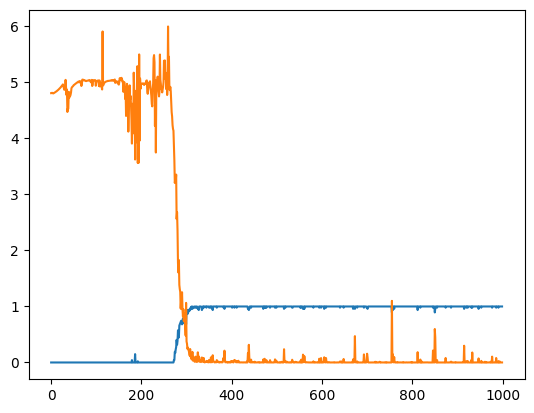

In [ ]:
#visualize the loss and accuracy
plt.plot(stepi, acc)
plt.plot(stepi, lossi)

In [ ]:
# #store the model after training
storage_path='/content/drive/MyDrive/models/grozi-120.pth'
torch.save(cnn.state_dict(), storage_path)

In [ ]:
#load the model after training
cnn = CNNNetwork().to(device)
state_dict = torch.load(storage_path)
cnn.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
#test on dev/test set || in-situ
@torch.no_grad()
def testing(model, data_loader, loss_fn, device):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        #get softmax predictions
        prediction = model(input)
        #softmax+categorical cross entropy
        loss = loss_fn(prediction, target)
        #accuracy
        predicted_labels=torch.argmax(prediction,dim=1)
        # Compare predicted labels with ground truth labels
        correct_predictions = (predicted_labels == target).sum().item()
        # Calculate accuracy
        accuracy = correct_predictions / len(target)

    print(f"loss: {loss.item()}")
    print(f"accuracy: {accuracy}")

In [ ]:
# #load in-situ test dataset
ANNOTATION_FILE='/content/drive/MyDrive/data/grozi-120/in-situ-data.csv'
IMAGE_DIR='/content/drive/MyDrive/data/grozi-120/inSitu/{}/video/'
mean_in_sito=[0.3352, 0.2702, 0.1694]
std_in_sito=[0.2260, 0.2049, 0.1556]
# #create dataset
products_in_situ=Products(ANNOTATION_FILE,IMAGE_DIR,device,mean_in_sito,std_in_sito)
# test_dataloader = create_data_loader(products_in_situ,len(products_in_situ))

In [ ]:
# #evaluate the performance on test dataset ||
test_dataloader = create_data_loader(products_in_situ,len(products_in_situ))
loss_func = nn.CrossEntropyLoss()
testing(cnn, test_dataloader, loss_func,device)

loss: 32.89826583862305
accuracy: 0.10833333333333334


In [ ]:
#inference for labeled dataset
@torch.no_grad()
def predict_target(cnn,input,target):
  #model.eval()
  prediction=cnn(input)
  softmax=nn.Softmax(dim=1)
  logits=softmax(prediction)
  predicted_index=logits[0].argmax(0)
  predicted=class_mapping[predicted_index]
  expected=class_mapping[target]
  return predicted,expected

In [ ]:
#inference
@torch.no_grad()
def predict(cnn,input):
  #model.eval()
  prediction=cnn(input)
  softmax=nn.Softmax(dim=1)
  logits=softmax(prediction)
  predicted_index=logits[0].argmax(0)
  predicted=class_mapping[predicted_index]
  return predicted,predicted_index

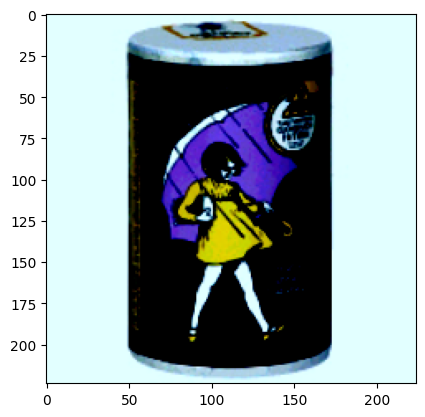

("'Morton Salt, Iodized',", "'Morton Salt, Iodized',")

In [ ]:
x,y=products_augm[1000]
x=x.cpu()
imshow(torchvision.utils.make_grid(x))
x=x.to(device)
#needs to be in batches for inference [b,nc,h,w]
x_batch = x.unsqueeze(0)
predict_target(cnn,x_batch,y)

In [ ]:
#loading images for inference with resize and normalize with mean/std from train dataset
class ProductsInference:

    def __init__(self,image_dir,device):
        self.image_dir=image_dir
        self.device=device
        self.transform=transform = transforms.Compose([
                         transforms.Resize((224,224)),
                         #mean/std from in-situ
                         transforms.Normalize((0.3352, 0.2702, 0.1694), (0.2260, 0.2049, 0.1556))
                         ])

    #get image,label
    def item(self):
        image=read_image(self.image_dir) #read image as a tensor
        image=image.type(torch.FloatTensor) #
        image=self.transform(image)
        image=image.to(device)
        image = image.unsqueeze(0)
        return image

In [ ]:
## INFERENCE(testing on images outside of the train/test dataset)
startburst='/content/drive/MyDrive/inference/grozi-120/vegetablethins.jpg'
products_inf=ProductsInference(image_dir=startburst,device=device)


In [ ]:
#make prediction || class label and probability
predict(cnn,products_inf.item())

"'Nabisco Flavor Crisps/Flavor Originals Snack Crackers Baked Vegetable Thins',"

In [ ]:
x=products_inf.item()
x=x.cpu()
imshow(torchvision.utils.make_grid(x))